<br>

<br>

# This next cell contains methods for generating data for training the feature extractor and data for environments 1, 2, and 3 by adding color to the MNIST images and binarizing the image labels.

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
import pandas as pd
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats



# Download and split MNIST data
mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:40000], mnist.targets[:40000])
mnist_test = (mnist.data[40000:], mnist.targets[40000:])
mnist_all = (mnist.data, mnist.targets)

#Shuffle the data
rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

rng_state = np.random.get_state()
np.random.shuffle(mnist_all[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_all[1].numpy())

# Splitting the data that will be used to train the feature extractor 
# into 80% train set and 20% test set
X_train = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train = mnist_all[1][:int(0.8*len(mnist_all[1]))] 
X_test = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test = mnist_all[1][int(0.8*len(mnist_all[1])):]


# used to binarize the target variable
def binarize(y, label_noise=0.):
    
    y = np.copy(y) > 4
    
    if label_noise > 0:
        y = np.logical_xor(y, np.random.binomial(1, label_noise, size=len(y)))
    
    return y.astype(int)

# used to randomly add color to the dataset used to train the feature extractor
def color_digits(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0    
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)



# used to color either the entire dataset green or the entire dataset red
def color_all_images_same_color(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
        
    if green:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.)




# Used to generate environments 1, 2, and 3 by varying the distribution of color
def generate_environments(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0
    
    colored_X = colored_X.reshape(X.shape[0],-1)
    
    return {
      'images': (colored_X.astype(float) / 255.),
      'labels': y[:, None],
      'colors': color[:, None]
    }

    
    
# Used to plot colored images    
def plot_images(X, n_row=10, n_col=10, shape=(2,14,14), scale=False):
    fig = plt.figure(figsize=(n_row, n_col))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
    for ax in grid:
        index = np.random.choice(np.arange(X.shape[0]))
        img = X[index].reshape(shape)
        if scale:
            img = img - img.min()
            img /= img.max()
        img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
        img = np.moveaxis(img, 0, -1)
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

<br>

# Define, train, and evaluate the feature extractor

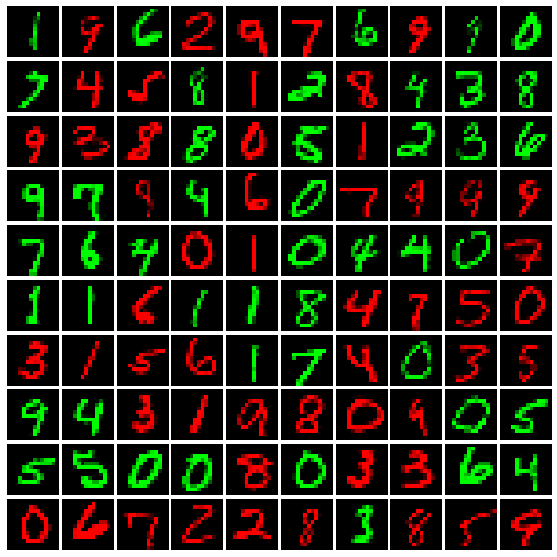

Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)
Label Accuracy:  0.9405833333333333
Color Accuracy:  1.0


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

class MLP(torch.nn.Module):

    def __init__(self, size=[2*14*14, 2]):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(size)-2):
            layers.append(torch.nn.Linear(size[i], size[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size[-2], size[-1]))
        self.net = torch.nn.Sequential(*layers)
        print(self.net)

    def forward(self, x):
        return self.net(x)

def tensor_numpy(arrays, device):
    out = []
    for a in arrays:
        out.append(torch.from_numpy(a).float().to(device))
    return out
    
    
np.random.seed(1)
label_noise = 0.
color_noise = None

y_train = binarize(y_train, label_noise=label_noise)
y_test = binarize(y_test, label_noise=label_noise)

X_train, color_train = color_digits(X_train, y_train, color_noise, downsample=True)
X_test, color_test = color_digits(X_test, y_test, color_noise, downsample=True)

plot_images(X_train)
# plot_images(X_test)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

hidden_size = [2*14*14, 50, 2]
net = MLP(hidden_size).to(device)

tr_x, tr_y, tr_c = tensor_numpy([X_train, y_train, color_train], device)
te_x, te_y, te_c = tensor_numpy([X_test, y_test, color_test], device)

bs = 256

tr_dataset = TensorDataset(tr_x, tr_y, tr_c)
tr_loader = DataLoader(tr_dataset, batch_size = bs, shuffle = True)
# te_dataset = TensorDataset(te_x, te_y, te_c)
# te_loader = DataLoader(te_dataset, batch_size = bs, shuffle = True)

loss_label = torch.nn.BCEWithLogitsLoss()
loss_color = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 10
for e in range(epoch):
    
    for x, y, c in tr_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss_y = loss_label(out[:,0], y)
        loss_c = loss_color(out[:,1], c)
        loss = loss_y + loss_c
        
        loss.backward()
        optimizer.step()
        
            
with torch.no_grad():
    test_preds = 1*(net(te_x).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(y_test, test_preds[:,0])
    acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
    print('Color Accuracy: ', acc_c)


<br>

# Use the trained feature extractor to extract features from data that will be used to train and test our classifiers

In [3]:
label_noise = 0.
color_noise = None


env1_X_train = mnist_train[0][::2]
env1_y_train = binarize(mnist_train[1][::2], label_noise=label_noise)

env2_X_train = mnist_train[0][1::2]
env2_y_train = binarize(mnist_train[1][1::2], label_noise=label_noise)

env3_X_train = mnist_test[0]
env3_y_train = binarize(mnist_test[1], label_noise=label_noise)

envs = [
generate_environments(env1_X_train, env1_y_train, 0.2),
generate_environments(env2_X_train, env2_y_train, 0.4),
generate_environments(env3_X_train, env3_y_train, 0.9)
]


class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()   
        net.eval()
        self.children_list = []
        for n,c in net.named_children():
            self.children_list.append(c)
            
        print("Printing all the trained model layers")
        print(self.children_list)
        self.children_list = self.children_list[0][:2]
        print("Printing model layers after dropping the output layer for feature extraction")    
        print(self.children_list)
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x


def extract_features(model,x,y, device = 'cpu'):
    extracted_features = []
    labels = []   
    with torch.no_grad():
        x = x.to(device)
        extracted_features = model(x.float())
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features_df = pd.DataFrame(extracted_features.numpy())
    extracted_features_df["target"] = y.cpu().numpy()
    return extracted_features_df



train_envs_1_and_2_inputs = torch.cat((torch.from_numpy(envs[0]['images']), torch.from_numpy(envs[1]['images'])), 0)
train_envs_1_and_2_targets = torch.cat((torch.from_numpy(envs[0]['labels']), torch.from_numpy(envs[1]['labels'])), 0)

print("Combined environments 1 and 2 data size - used to train our final prediction models")
print(len(train_envs_1_and_2_inputs))
print(len(train_envs_1_and_2_targets))

test_inputs =torch.from_numpy(envs[2]['images'])
test_targets =torch.from_numpy(envs[2]['labels'])

print("Environment 3 data size - used to test our final prediction models")
print(len(test_inputs))
print(len(test_targets))

feature_extractor = feature_extractor()

train_extracted_features_df = extract_features(feature_extractor,train_envs_1_and_2_inputs, train_envs_1_and_2_targets)
test_extracted_features_df = extract_features(feature_extractor,test_inputs, test_targets)


print("Printing the extracted features - first train features followed by test features shape/size!!!")
# print(train_extracted_features_df)
print(train_extracted_features_df.shape)
# print(test_extracted_features_df)
print(test_extracted_features_df.shape)


Combined environments 1 and 2 data size - used to train our final prediction models
40000
40000
Environment 3 data size - used to test our final prediction models
20000
20000
Printing all the trained model layers
[Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)]
Printing model layers after dropping the output layer for feature extraction
Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
)
Printing the extracted features - first train features followed by test features shape/size!!!
(40000, 51)
(20000, 51)


<br>

<br>

# In this next cell, we create two sets of images; images that are all colored green and images that are all colored red. We then use the trained feature extractor to extract features from green images and features red images. Finally we take the difference between green image features and red image features and plot the histograms of features obtained from this difference.

All images colored green


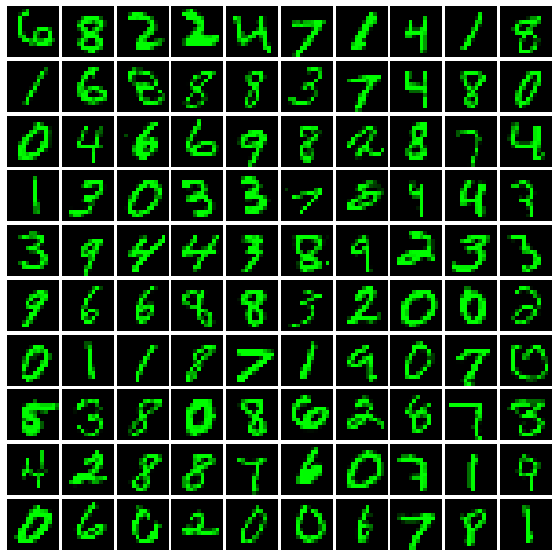

All images colored red


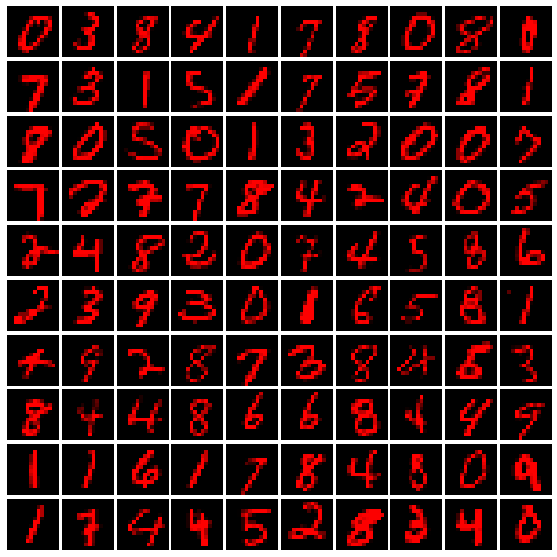

(48000, 50)

(48000, 50)

Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.557295,1.796006,1.185138,1.291586,1.044838,1.866423,2.124517,1.362167,3.173831,1.319917,...,2.235521,2.379349,1.037772,1.655581,2.438779,2.112527,0.350726,1.458474,2.204137,2.159626
1,1.156572,3.790333,2.659641,4.911051,1.095889,1.491978,4.419471,3.056877,5.931451,2.608467,...,1.469359,3.227175,2.667442,2.719112,2.595657,0.196923,3.880475,3.085725,4.234104,4.209820
2,0.898499,2.091843,2.819638,4.112676,0.566697,1.165113,2.428776,1.335555,3.449240,0.519628,...,2.716995,2.441912,1.591895,2.589668,2.980674,2.655566,2.822259,2.676916,2.655257,3.184838
3,0.866847,0.128153,1.997401,3.957902,1.167690,0.993019,3.025630,0.462758,0.364256,2.174132,...,2.556674,1.967180,2.042955,1.851246,2.970294,2.095991,2.941354,0.781153,2.932862,3.184577
4,0.947212,2.130556,0.312165,3.404214,0.200903,0.301567,2.337957,1.548504,3.362544,0.473171,...,2.399134,0.926831,1.327758,1.646736,2.643593,2.419469,2.274382,0.928000,2.485126,2.623158


Histogram for feature  0


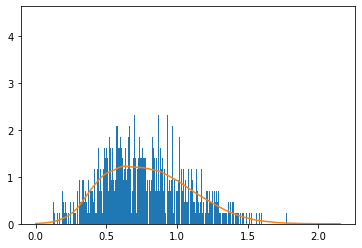

Histogram for feature  1


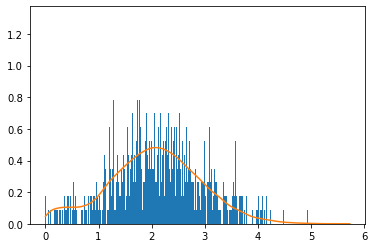

Histogram for feature  2


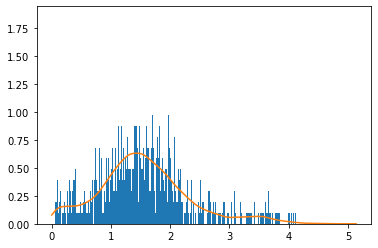

Histogram for feature  3


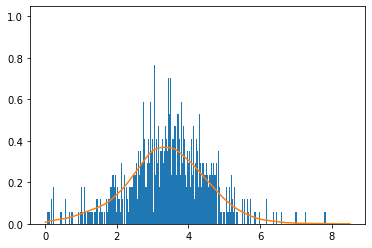

Histogram for feature  4


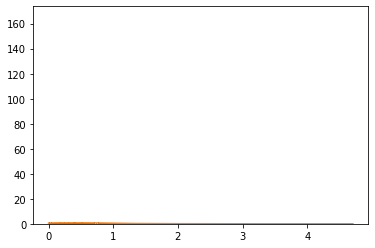

Histogram for feature  5


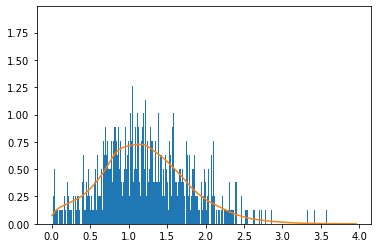

Histogram for feature  6


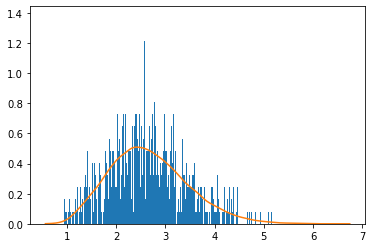

Histogram for feature  7


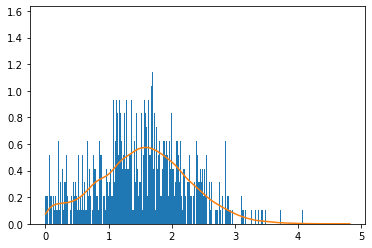

Histogram for feature  8


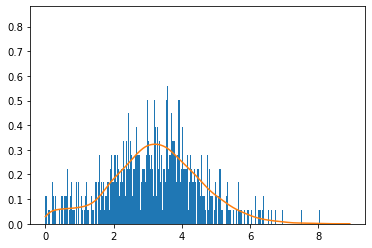

Histogram for feature  9


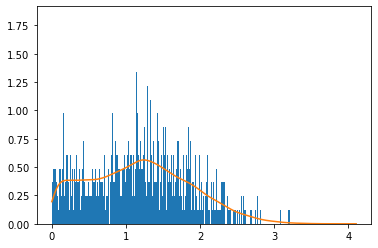

Histogram for feature  10


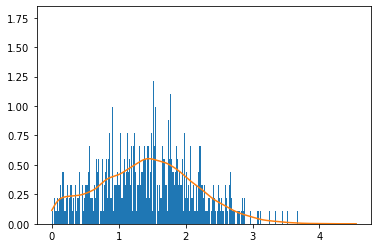

Histogram for feature  11


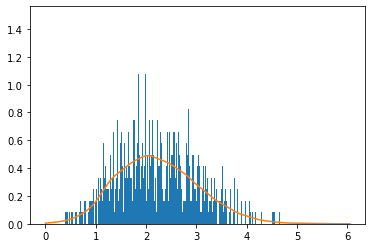

Histogram for feature  12


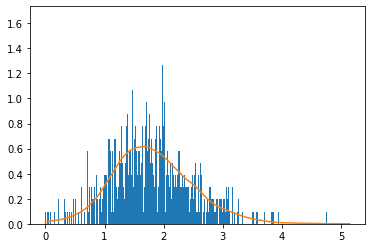

Histogram for feature  13


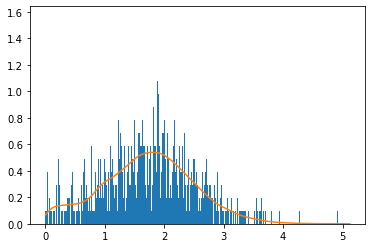

Histogram for feature  14


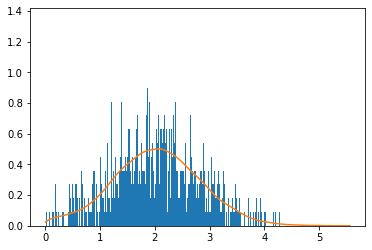

Histogram for feature  15


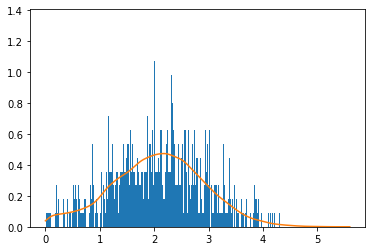

Histogram for feature  16


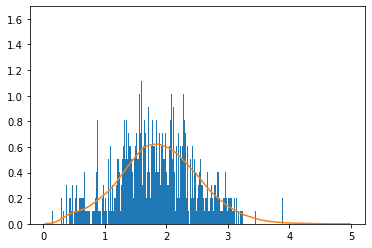

Histogram for feature  17


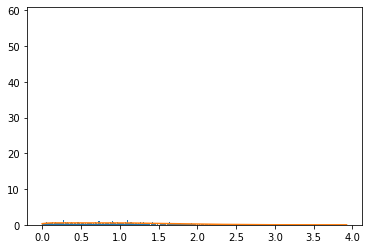

Histogram for feature  18


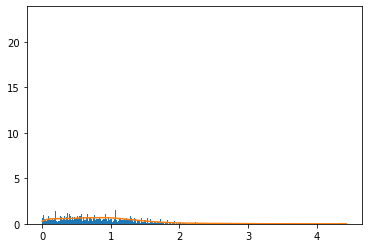

Histogram for feature  19


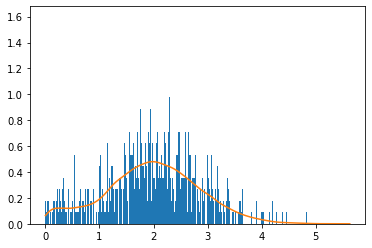

Histogram for feature  20


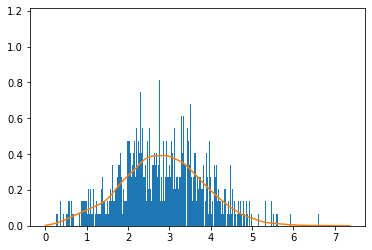

Histogram for feature  21


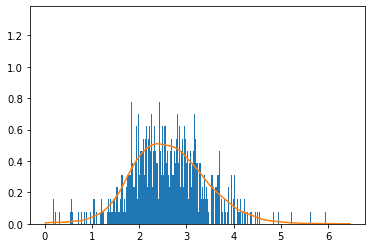

Histogram for feature  22


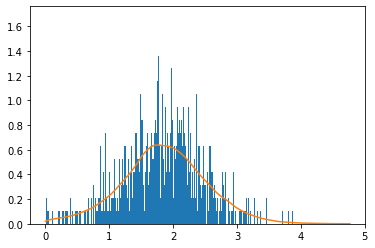

Histogram for feature  23


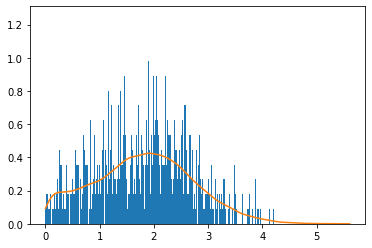

Histogram for feature  24


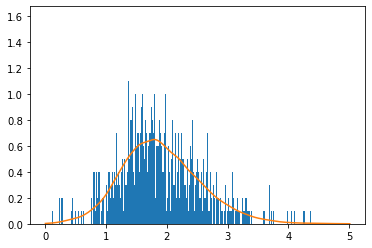

Histogram for feature  25


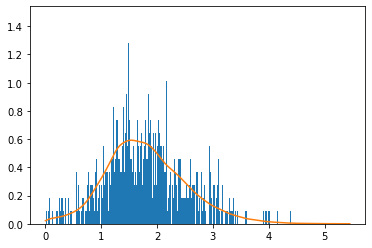

Histogram for feature  26


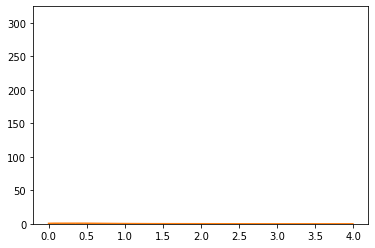

Histogram for feature  27


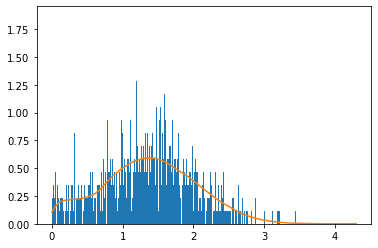

Histogram for feature  28


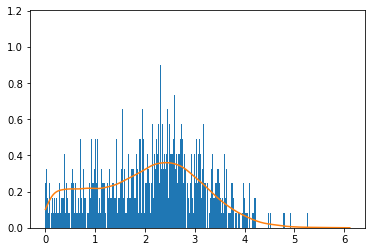

Histogram for feature  29


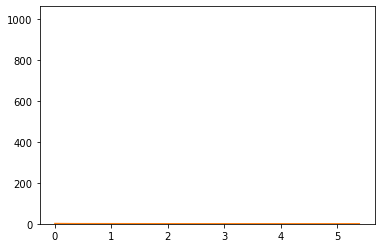

Histogram for feature  30


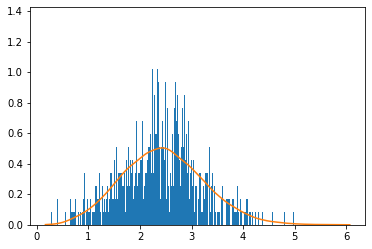

Histogram for feature  31


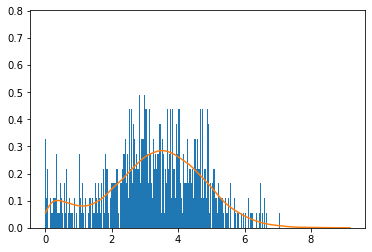

Histogram for feature  32


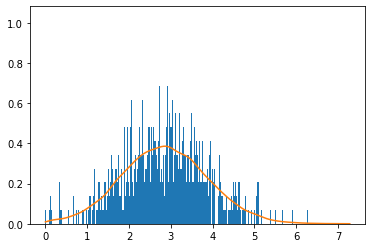

Histogram for feature  33


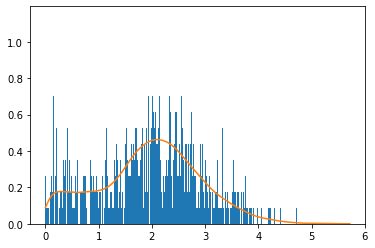

Histogram for feature  34


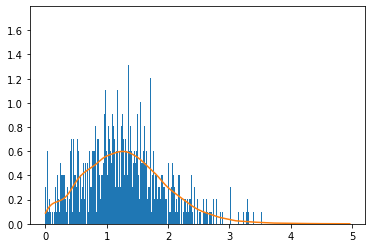

Histogram for feature  35


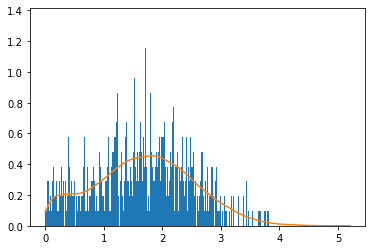

Histogram for feature  36


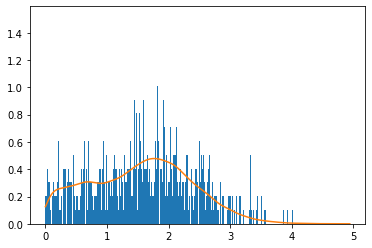

Histogram for feature  37


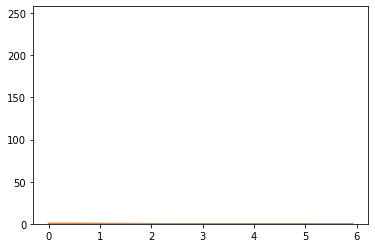

Histogram for feature  38


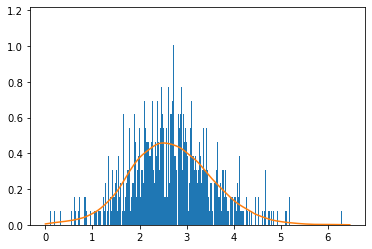

Histogram for feature  39


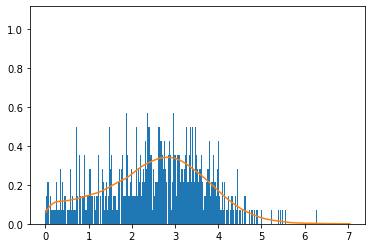

Histogram for feature  40


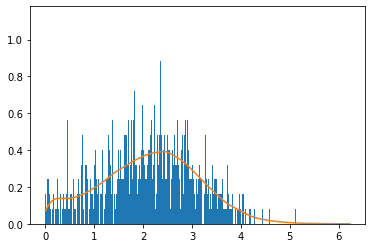

Histogram for feature  41


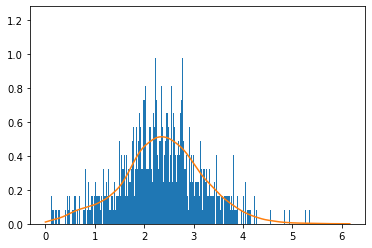

Histogram for feature  42


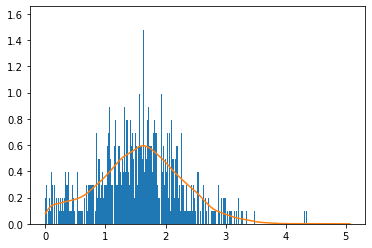

Histogram for feature  43


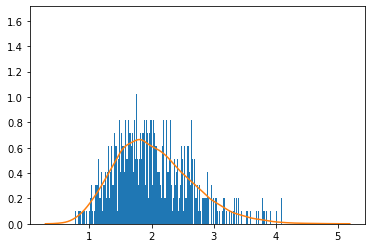

Histogram for feature  44


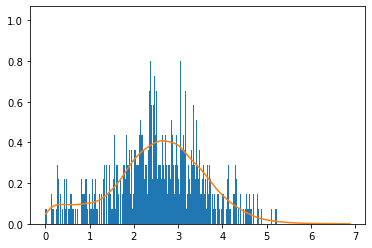

Histogram for feature  45


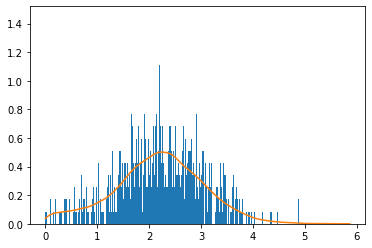

Histogram for feature  46


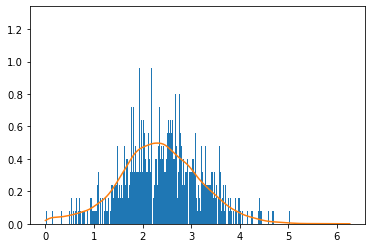

Histogram for feature  47


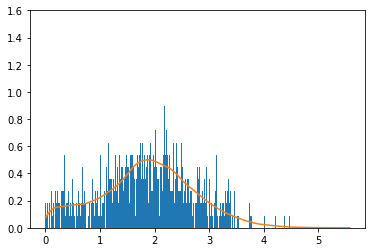

Histogram for feature  48


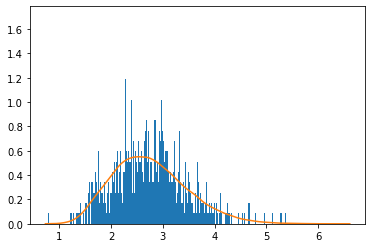

Histogram for feature  49


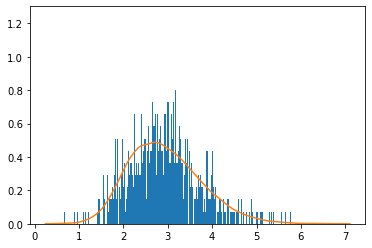

In [4]:
X_train_ = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train_ = mnist_all[1][:int(0.8*len(mnist_all[1]))]

y_train = binarize(y_train, label_noise=label_noise)

# Color all images red
red_images = color_all_images_same_color(X_train_, green=False)

# Color all images green
green_images = color_all_images_same_color(X_train_, green=True)

print("All images colored green")
plot_images(green_images)

print("All images colored red")
plot_images(red_images)


# extract features from green images
green_image_features = extract_features(feature_extractor,torch.from_numpy(green_images), 
                                        y_train_).to_numpy()[:, :-1]

display(green_image_features.shape)

# extract features from red images
red_image_features = extract_features(feature_extractor,torch.from_numpy(red_images), 
                                      y_train_).to_numpy()[:, :-1]

display(red_image_features.shape)

# the difference between extracted green image features and red image features
delta_matrix = np.absolute(green_image_features - red_image_features)

print("Printing the delta matrix")
delta_matrix_df = pd.DataFrame(delta_matrix)
display(delta_matrix_df.head())

# Plotting the histograms for each feature in the delta matrix
for i in range(len(delta_matrix_df.columns)): 
    print("Histogram for feature ", i)    
    feature = delta_matrix_df.iloc[:,i].values
    density = stats.gaussian_kde(feature)
    n, x, _ = plt.hist(feature, bins=np.linspace(np.amin(delta_matrix_df.iloc[:,i]), np.amax(delta_matrix_df.iloc[:,i]), 24000), 
                       histtype='bar', density=True)  
    plt.plot(x, density(x))
    plt.show()



# Plain Linear Classifier

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from numpy import vstack
from numpy import sqrt

# train_data_path = './data/mnist_train_extracted_features.csv'
# test_data_path = './data/mnist_test_extracted_features.csv'

train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df

#***** Obtaining the within training environment test data
train, within_test = train_test_split(train_data_path, test_size=0.5, random_state=100)


def read_data(path):
#     data_df = pd.read_csv(path).to_numpy()
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch




class LogisticRegression(torch.nn.Module):
    def __init__(self, d):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(d,1)

    def forward(self, x):
        y_hat = self.linear(x)
        return torch.sigmoid(y_hat)

    
   
    
# train the model
def train_model(inputs, targets, model):
    # define the optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    
    for epoch in range(1000):        
        optimizer.zero_grad() 
        y_hat = model(inputs.float())
        loss = criterion(y_hat.float(), targets.float())
        loss.backward()
        optimizer.step()
      
        

# evaluate the model
def model_eval(inputs, targets, model):
    predictions, actuals = list(), list()
    yhat = model.forward(inputs.float())
    yhat = np.where(yhat.detach().numpy() < 0.5, 0, 1)
    actual = targets.detach().cpu().numpy()
    actual = actual.reshape((len(actual), 1))
    yhat = yhat.reshape((len(yhat), 1))

    predictions.append(yhat)
    actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
#     calculate accuracy
    acc = accuracy_score(actuals, predictions)
#     acc = accuracy_score(actual, yhat)
    return acc


X_torch_train, targets_torch_train = read_data(train_data_path)
X_torch_test, targets_torch_test = read_data(test_data_path)
X_torch_test_within, targets_torch_test_within = read_data(within_test)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)

d = X_torch_train.shape[1]

print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)

model = LogisticRegression(d) 

train_model(X_torch_train, targets_torch_train, model)
accuracy = model_eval(X_torch_test, targets_torch_test, model)
accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)

print('Plain Logistic Regression Accuracy within training env: ',accuracy_within.round(4))
print('Plain Logistic Regression Accuracy on env 3: ', accuracy.round(4))



# accuracy_list = []
# within_accuracy_list = []
# print("Mean accuracies after 10 runs:")
# for i in range(10):
#     train_model(X_torch_train, targets_torch_train, model)
#     accuracy = model_eval(X_torch_test, targets_torch_test, model)
#     accuracy_within = model_eval(X_torch_test_within, targets_torch_test_within, model)
#     accuracy_list.append(accuracy)
#     within_accuracy_list.append(accuracy_within)
# print()
# print('Plain Logistic Regression Mean Accuracy within training env: ', np.mean(within_accuracy_list).round(4), 
#       'std: ', np.std(within_accuracy_list).round(3))
# print('Plain Logistic Regression Mean Accuracy on env 3: ', np.mean(accuracy_list).round(4), 'std: ', 
#       np.std(accuracy_list).round(3))


Printing the shape of the input!
torch.Size([40000, 50])
Printing the shape of the target!
torch.Size([40000, 1])
Plain Logistic Regression Accuracy within training env:  0.9468
Plain Logistic Regression Accuracy on env 3:  0.8634


In [6]:

within_imgs = train_envs_1_and_2_inputs[:int(0.5*(len(train_envs_1_and_2_inputs)))]
within_img_targets = train_envs_1_and_2_targets[:int(0.5*(len(train_envs_1_and_2_inputs)))]
print(within_img_targets.shape)

print(within_imgs.shape)
with torch.no_grad():
    test_preds = 1*(net(within_imgs.float()).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(within_img_targets, test_preds[:,0])
#     acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
#     print('Color Accuracy: ', acc_c)


with torch.no_grad():
    test_preds = 1*(net(test_inputs.float()).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(test_targets, test_preds[:,0])
#     acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
#   


# test_inputs =torch.from_numpy(envs[2]['images'])
# test_targets =torch.from_numpy(envs[2]['labels'])



torch.Size([20000, 1])
torch.Size([20000, 392])
Label Accuracy:  0.9437
Label Accuracy:  0.94945


In [7]:
# from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
# X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0).fit(X_torch_train.numpy(), targets_torch_train.numpy())
# clf.predict(X[:2, :])
# array([0, 0])
# clf.predict_proba(X[:2, :])
# array([[9.8...e-01, 1.8...e-02, 1.4...e-08],
#        [9.7...e-01, 2.8...e-02, ...e-08]])
clf.score(X_torch_test_within.numpy(), targets_torch_test_within.numpy())


/software/anaconda3/envs/castle_env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/castle_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.95565

<br>

# Linear Classifier with NOTEARS (without threshold)

In [8]:
#####################################################################################################################
# Some parts of the code in this cell are from: Zheng, Xun, et al. "Dags with no tears: Continuous optimization for 
# structure learning." Advances in Neural Information Processing Systems 31 (2018). 
# Their code is available here https://github.com/xunzheng/notears
######################################################################################################################


import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid
import pandas as pd
from sklearn import preprocessing
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split



from numpy import vstack
from numpy import sqrt


# train_data_path = './data/mnist_train_extracted_features.csv'
# test_data_path = './data/mnist_test_extracted_features.csv'

train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df

#***** Obtaining the within training environment test data
train, within_test = train_test_split(train_data_path, test_size=0.5, random_state=100)




def read_data(path):
#     data = pd.read_csv(path).to_numpy()
    data = path.to_numpy()
    
    X = data.copy()
    targets = X[:, -1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(data)
    data = sscaler.transform(data)
    return data,targets


def notears_linear(X, y, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        
        yhat = M[:, -1]
        targets = y
        criterion = torch.nn.BCELoss()
        
        yhat = torch.from_numpy(yhat)
        targets = torch.from_numpy(targets)
        
        yhat = torch.sigmoid(yhat) 
        
        yhat = yhat.reshape(-1,1)
        targets = targets.reshape(-1,1)
        
        if loss_type == 'l2':
            R = X - M
            loss_pred = criterion(yhat.float(), targets.float())
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss_pred = criterion(yhat, targets)
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            loss_pred = criterion(yhat, targets)
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, loss_pred, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, loss_pred, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + loss_pred + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
#     W_est[np.abs(W_est) < w_threshold] = 0
    return W_est




# evaluate the model
def model_eval(inputs, targets, W):
    reconstructed_inputs = inputs @ W
    
    yhat = torch.from_numpy(reconstructed_inputs[:, -1])
    targets = torch.from_numpy(targets)
    
    yhat = torch.sigmoid(yhat) 
    yhat = np.where(yhat.detach().numpy() < 0.5, 0, 1)
    
    actual = targets.cpu().numpy()
    actual = actual.reshape((len(actual), 1))
    yhat = yhat.reshape((len(yhat), 1))
    # calculate accuracy
    acc = accuracy_score(actual, yhat)
    return acc




if __name__ == '__main__':
    
    X_train, train_targets = read_data(train_data_path)
    X_test, test_targets = read_data(test_data_path)
    
    X_test_within, targets_test_within = read_data(within_test)
    W_est = notears_linear(X_train,train_targets, lambda1=0.1, loss_type='l2')
    
    print("Final DAG!!!!!")
    print(W_est)
    
    accuracy = model_eval(X_test, test_targets, W_est)
    accuracy_within = model_eval(X_test_within, targets_test_within, W_est)
    print('Linear Model with NOTEARS Accuracy within training env: %.3f' % accuracy_within)
    print('Linear Model with NOTEARS Accuracy on env 3: %.3f' % accuracy)
    
    np.savetxt('W_est.csv', W_est, delimiter=',')
    
#     accuracy_list_notears = []
#     within_accuracy_list_notears = []
#     print("Mean accuracies after 10 runs:")
#     for i in range(10):
#         W_est = notears_linear(X_train,train_targets, lambda1=0.1, loss_type='l2')
#         accuracy_notears = model_eval(X_test, test_targets, W_est)
#         accuracy_within_notears = model_eval(X_test_within, targets_test_within, W_est)
        
#         print("Print the within accuracy at iteration i:")
#         print(accuracy_within_notears)
#         print("Print the accuracy on env 3 at iteration i: ")
#         print(accuracy_notears)
        
#         accuracy_list_notears.append(accuracy_notears)
#         within_accuracy_list_notears.append(accuracy_within_notears)
#     print()
    
#     print("Print the within accuracy list:")
#     print(within_accuracy_list_notears)
#     print("Print the accuracy list on env 3:")
#     print(accuracy_list_notears)
    
#     print('Linear Model with NOTEARS Mean Accuracy within training env: ', np.mean(within_accuracy_list_notears).round(4), 
#           'std: ', np.std(within_accuracy_list_notears).round(3))
#     print('Linear Model with NOTEARS Mean Accuracy on env 3: ', np.mean(accuracy_list_notears).round(4), 'std: ', 
#           np.std(accuracy_list_notears).round(3))






Final DAG!!!!!
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   9.86228108e-05  1.16793559e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.43919134e-07
  -3.33717087e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.35148420e-03
   2.16252371e-07 -2.37281211e-02]
 ...
 [ 0.00000000e+00  1.19865429e-02  0.00000000e+00 ...  0.00000000e+00
  -3.87785499e-06  0.00000000e+00]
 [ 0.00000000e+00 -1.74735522e-05  0.00000000e+00 ... -4.08736014e-02
   0.00000000e+00  0.00000000e+00]
 [ 1.05499222e-07  0.00000000e+00 -3.40696466e-07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Linear Model with NOTEARS Accuracy within training env: 0.863
Linear Model with NOTEARS Accuracy on env 3: 0.558


<br>

<br>

# Analysis of causal features and features with high correlation coefficients to color and label targets in the feature extractor

## Correlation coefficients

In [9]:
# All the weights of the feature extractor
all_weights = list(net.parameters())
all_weights

[Parameter containing:
 tensor([[ 3.6478e-38,  1.6475e-38,  6.2571e-38,  ...,  1.0044e-01,
          -3.3381e-04, -2.1127e-38],
         [ 6.0339e-38,  5.0943e-38, -7.2329e-39,  ..., -7.2290e-02,
           7.7655e-07, -2.1257e-38],
         [ 6.1776e-39, -2.5823e-38, -1.4081e-38,  ..., -2.1335e-03,
          -6.5437e-39, -2.6024e-38],
         ...,
         [ 4.0529e-38, -1.1667e-38,  3.9582e-38,  ...,  1.7829e-01,
          -5.6620e-38, -2.5397e-38],
         [-1.1917e-38, -1.8324e-38, -1.9456e-38,  ...,  1.1158e-02,
           2.6055e-07,  1.8355e-38],
         [ 4.6797e-38, -6.6192e-38, -1.5862e-38,  ...,  2.8451e-02,
           1.0165e-06, -7.8155e-39]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0165,  0.1667,  0.0948,  0.2329,  0.0572, -0.0080,  0.1426,  0.1478,
          0.2209,  0.1536,  0.0642,  0.0754,  0.0787,  0.1441,  0.1588,  0.1590,
          0.0989,  0.2222,  0.0598,  0.1210,  0.1995,  0.1877,  0.1278,  0.2352,
          0.0800,  0.0476,  0.0664,  0.1895, 

In [10]:
# Extract coeficients of features for the label and coeficients of features for the color
label_coefficients = all_weights[2][0]
print("Printing Label Coeficients:")
display(label_coefficients)
color_coefficients = all_weights[2][1]
print("Printing Color Coeficients:")
display(color_coefficients)

Printing Label Coeficients:


tensor([ 0.2892, -0.2328, -0.6943,  0.2259, -0.7405,  0.5071, -0.0508, -0.3501,
        -0.1803, -0.5284, -0.5075, -0.1714,  0.4452, -0.3623, -0.2892, -0.2007,
        -0.1151, -0.8029, -0.7217, -0.1817,  0.1880,  0.1888,  0.3896, -0.5834,
         0.3710,  0.4001, -0.6382, -0.5325,  0.4268, -0.6546,  0.1738,  0.3585,
         0.1607,  0.5459, -0.6663, -0.3694, -0.3057, -0.6968,  0.1862,  0.5106,
         0.3814,  0.1911, -0.6286,  0.3715,  0.2866,  0.3035,  0.1513,  0.5962,
         0.0161,  0.1200], grad_fn=<SelectBackward0>)

Printing Color Coeficients:


tensor([-0.1316,  0.2996, -0.2113,  0.3248,  0.1285,  0.2244,  0.3219, -0.2144,
        -0.2400, -0.2085, -0.3044,  0.3586, -0.2024,  0.2741,  0.3062,  0.2903,
        -0.3180,  0.1134,  0.1721, -0.3114,  0.3382,  0.3729,  0.1938,  0.1205,
        -0.2091, -0.3845,  0.1279, -0.2338,  0.1948, -0.1331,  0.2899, -0.3014,
        -0.2675, -0.3512, -0.2724, -0.2249, -0.2726, -0.2593,  0.2960,  0.2215,
        -0.3074,  0.2871,  0.1276, -0.2691, -0.3685,  0.2812,  0.3166, -0.2677,
         0.3305, -0.3389], grad_fn=<SelectBackward0>)

In [11]:
# Sorted features from highest to lowest absolute value of coefficients for label
Sorted_features_highest_to_lowest_coefs_label = torch.argsort(label_coefficients.abs(), descending=True)
print("Printing out indeces of sorted features from highest to lowest coefficients for label")
display(Sorted_features_highest_to_lowest_coefs_label)
print("Printing out feature correlation coefficients from highest to lowest for label")
display(label_coefficients[Sorted_features_highest_to_lowest_coefs_label])



# Sorted features from highest to lowest absolute value of coefficients for color
Sorted_features_highest_to_lowest_coefs_color = torch.argsort(color_coefficients.abs(), descending=True)
print("Printing out indeces of sorted features from highest to lowest coefficients for color")
display(Sorted_features_highest_to_lowest_coefs_color)
print("Printing out feature correlation coefficients from highest to lowest for label")
color_coefficients[Sorted_features_highest_to_lowest_coefs_color]

Printing out indeces of sorted features from highest to lowest coefficients for label


tensor([17,  4, 18, 37,  2, 34, 29, 26, 42, 47, 23, 33, 27,  9, 39, 10,  5, 12,
        28, 25, 22, 40, 43, 24, 35, 13, 31,  7, 36, 45, 14,  0, 44,  1,  3, 15,
        41, 21, 20, 38, 19,  8, 30, 11, 32, 46, 49, 16,  6, 48])

Printing out feature correlation coefficients from highest to lowest for label


tensor([-0.8029, -0.7405, -0.7217, -0.6968, -0.6943, -0.6663, -0.6546, -0.6382,
        -0.6286,  0.5962, -0.5834,  0.5459, -0.5325, -0.5284,  0.5106, -0.5075,
         0.5071,  0.4452,  0.4268,  0.4001,  0.3896,  0.3814,  0.3715,  0.3710,
        -0.3694, -0.3623,  0.3585, -0.3501, -0.3057,  0.3035, -0.2892,  0.2892,
         0.2866, -0.2328,  0.2259, -0.2007,  0.1911,  0.1888,  0.1880,  0.1862,
        -0.1817, -0.1803,  0.1738, -0.1714,  0.1607,  0.1513,  0.1200, -0.1151,
        -0.0508,  0.0161], grad_fn=<IndexBackward0>)

Printing out indeces of sorted features from highest to lowest coefficients for color


tensor([25, 21, 44, 11, 33, 49, 20, 48,  3,  6, 16, 46, 19, 40, 14, 10, 31,  1,
        38, 15, 30, 41, 45, 13, 36, 34, 43, 47, 32, 37,  8, 27, 35,  5, 39,  7,
         2, 24,  9, 12, 28, 22, 18, 29,  0,  4, 26, 42, 23, 17])

Printing out feature correlation coefficients from highest to lowest for label


tensor([-0.3845,  0.3729, -0.3685,  0.3586, -0.3512, -0.3389,  0.3382,  0.3305,
         0.3248,  0.3219, -0.3180,  0.3166, -0.3114, -0.3074,  0.3062, -0.3044,
        -0.3014,  0.2996,  0.2960,  0.2903,  0.2899,  0.2871,  0.2812,  0.2741,
        -0.2726, -0.2724, -0.2691, -0.2677, -0.2675, -0.2593, -0.2400, -0.2338,
        -0.2249,  0.2244,  0.2215, -0.2144, -0.2113, -0.2091, -0.2085, -0.2024,
         0.1948,  0.1938,  0.1721, -0.1331, -0.1316,  0.1285,  0.1279,  0.1276,
         0.1205,  0.1134], grad_fn=<IndexBackward0>)

<br>

<br>

## Causal features

In [12]:
features_with_direct_links_to_the_label1 = W_est[0,:][1:]
display(features_with_direct_links_to_the_label1.shape)
features_with_direct_links_to_the_label2 = W_est[:,-1][1:]
features_with_direct_links_to_the_label2.shape

(50,)

(50,)

In [13]:
# Sorted features from most causal to least causal group 1
sorted_features_most__causal_to_least1 = torch.argsort(torch.from_numpy(features_with_direct_links_to_the_label1).abs(),descending=True)
print("Printing out indeces of sorted features from most causal to least causal group 1")
display(sorted_features_most__causal_to_least1)
print("Printing out feature causal coefficients from highest to lowest from group 1")
display(features_with_direct_links_to_the_label1[sorted_features_most__causal_to_least1])

print()

# Sorted features from most causal to least causal group 2
sorted_features_most__causal_to_least2 = torch.argsort(torch.from_numpy(features_with_direct_links_to_the_label2).abs(), descending=True)
print("Printing out indeces of sorted features from most causal to least causal group 2")
display(sorted_features_most__causal_to_least2)
print("Printing out feature causal coefficients from highest to lowest from group 2")
display(features_with_direct_links_to_the_label2[sorted_features_most__causal_to_least2])





Printing out indeces of sorted features from most causal to least causal group 1


tensor([28, 49, 34, 48,  7, 42, 11, 31, 46, 30, 43,  4, 24, 23, 29, 38, 32, 33,
        25, 35, 36, 37, 39, 40, 41, 44, 45, 47, 14,  1,  2,  3,  5,  6,  8,  9,
        10, 12, 13, 27, 15, 16, 17, 18, 19, 20, 21, 22,  0, 26])

Printing out feature causal coefficients from highest to lowest from group 1


array([-3.08735185e-01,  1.16793559e-01,  2.04179435e-04,  9.86228108e-05,
        2.94508773e-05,  4.74834477e-06,  1.23955315e-06,  1.04465809e-06,
        7.82587611e-08,  6.71488606e-08,  5.34301627e-08,  2.41000337e-08,
        1.67454379e-08,  1.53735551e-08,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])


Printing out indeces of sorted features from most causal to least causal group 2


tensor([ 4, 38, 28,  8, 36, 33, 16,  1, 22, 17, 41,  3, 25,  2, 32,  7, 34, 35,
         6, 37,  5, 39, 40, 31, 42, 43, 44, 45, 46, 47, 48, 49, 10, 14, 15, 12,
        11, 18, 19, 20, 21, 13, 23, 24,  0, 26, 27,  9, 29, 30])

Printing out feature causal coefficients from highest to lowest from group 2


array([ 2.78665291e-01,  1.63605879e-01, -1.37984339e-01, -1.04517385e-01,
       -9.84530853e-02, -7.02714383e-02, -4.48915668e-02, -2.37281211e-02,
       -6.64107146e-04, -2.38021852e-06, -6.73740516e-07, -3.00777022e-07,
       -2.01419051e-07,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [14]:
all_causal_feature_indeces = np.union1d(sorted_features_most__causal_to_least1.numpy()[:16], sorted_features_most__causal_to_least2.numpy()[:16])  

all_causal_feature_indeces

array([ 1,  2,  3,  4,  7,  8, 11, 16, 17, 22, 23, 24, 25, 28, 29, 30, 31,
       32, 33, 34, 36, 38, 41, 42, 43, 46, 48, 49])

In [15]:
# Identifying features that are correlated to label, but are also in the causal feature set to label

label_corr_and_causal_features_intersection = np.intersect1d(all_causal_feature_indeces, Sorted_features_highest_to_lowest_coefs_label.numpy()[:26] )
label_corr_and_causal_features_intersection


array([ 2,  4, 17, 22, 23, 24, 25, 28, 29, 33, 34, 42, 43])

In [16]:
# Identifying features that are correlated to color, but are also in the causal feature set to label 

color_corr_and_causal_features_intersection = np.intersect1d(all_causal_feature_indeces, Sorted_features_highest_to_lowest_coefs_color.numpy()[:26] )
color_corr_and_causal_features_intersection


array([ 1,  3, 11, 16, 25, 30, 31, 33, 34, 36, 38, 41, 46, 48, 49])

In [17]:
# Identifying features that are correlated to both color and label

color_corr_and_label_corr= np.intersect1d(Sorted_features_highest_to_lowest_coefs_label.numpy()[:26], Sorted_features_highest_to_lowest_coefs_color.numpy()[:26] )
color_corr_and_label_corr



array([10, 13, 25, 33, 34, 40])